In [1]:
from astropy.io import fits
import numpy as np
import aplpy
import matplotlib.pyplot as plt
from scipy.ndimage import binary_closing
import sys
import warnings 
import colorcet as cc

sys.path.append('./../modules/')
warnings.filterwarnings('ignore')

from tools_contsub_misc import *
from tools_contsub_anchoring import * 
from tools_contsub_plots import *

plt.rcParams["font.family"] = "sans-serif"
plt.rcParams["font.weight"] = "bold"
plt.rcParams["axes.labelweight"] = "bold"
plt.rcParams["xtick.direction"] = "in"
plt.rcParams["ytick.direction"] = "in" 

import warnings 
warnings.filterwarnings('ignore')

In [2]:
from astropy.nddata import Cutout2D
from astropy.wcs import WCS
from astropy.coordinates import SkyCoord

def get_croppeddata(hdu, ra, dec, size, smooth=False):

    wcs = WCS(hdu)  
    position = SkyCoord(ra=ra, dec=dec, frame='icrs')
    cutout = Cutout2D(hdu.data, position, [size*2.1, size*2.1], wcs=wcs)  
    hdu_crop = fits.PrimaryHDU(cutout.data, cutout.wcs.to_header())
    
    if smooth:
        hdu_crop = get_smooth(hdu_crop)

    del hdu, cutout
    return (hdu_crop)  

In [3]:
# Deinfe colours
cmap1 = plt.cm.binary(np.linspace(0, 1, 32))
cmap2 = colorcet.cm.fire(np.linspace(0, 1, 256))
cmaplist = np.vstack((cmap1, cmap2))
cmap_map = mpl.colors.LinearSegmentedColormap.from_list('my_colormap', cmaplist)
cmap_map.set_under(cmap_map(0))
cmap_map.set_bad(color=cmap_map(0))

In [4]:
rootdir = '/Users/abarnes/Dropbox/work/Smallprojects/galaxies/data_hstha/' 

hdu_ngc1672_w555 = fits.open(f'{rootdir}ngc1672/hst_contsub/ngc1672_hst_ha.fits')[0]
hdu_ngc1672_w550 = fits.open(f'{rootdir}ngc1672/hst_contsub_f550m/ngc1672_hst_ha.fits')[0]

hdu_ngc3351_w555 = fits.open(f'{rootdir}ngc3351/hst_contsub/ngc3351_hst_ha.fits')[0]
hdu_ngc3351_w547 = fits.open(f'{rootdir}ngc3351/hst_contsub_f547m/ngc3351_hst_ha.fits')[0]

In [5]:
ra = 71.4334579 *u.deg
dec = -59.2443655 *u.deg
size = 0.03 *u.deg

hdu_ngc1672_w555      = get_croppeddata(hdu_ngc1672_w555, ra, dec, size)
hdu_ngc1672_w550      = get_croppeddata(hdu_ngc1672_w550, ra, dec, size)

ra = 160.9859686 *u.deg
dec = 11.6977952 *u.deg
size = 0.02 *u.deg

hdu_ngc3351_w555      = get_croppeddata(hdu_ngc3351_w555, ra, dec, size)
hdu_ngc3351_w547      = get_croppeddata(hdu_ngc3351_w547, ra, dec, size)

In [6]:
# Update units and scaling... 

hdus = [hdu_ngc1672_w555, hdu_ngc1672_w550, hdu_ngc3351_w555, hdu_ngc3351_w547]

for i, hdu in enumerate(hdus):

    hdu.data[hdu.data==0] = np.nan
    # hdu.data = np.log10(hdu.data)

    try: 
        pix_size = (hdu.header['CD2_2']*u.deg).to('arcsec')
        pix_size = abs(pix_size.value)
        # print('pix_size: %0.2f' %pix_size)
    except:
        pix_size = (hdu.header['PC2_2']*u.deg).to('arcsec')
        pix_size = abs(pix_size.value)
        # print('pix_size: %0.2f' %pix_size)

    pix_area = pix_size**2
    unit = u.erg/u.s/u.cm**2/u.A

    hdu.data = hdu.data / pix_area

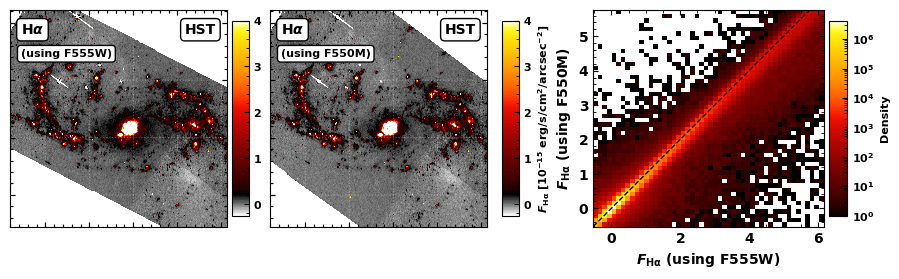

In [12]:
## Plot Maps... 
fig = plt.figure(figsize=(10, 10))
fig.tight_layout(h_pad=0, w_pad=0)
fig.subplots_adjust(left=0.05, right=0.95, top=0.95, bottom=0.05, wspace=-0.25, hspace=0.05)

vmin, vmax = -0.25*1e5, 4*1e5

hdus = [hdu_ngc1672_w555, hdu_ngc1672_w550]
label = [r'HST H$\alpha$ (using F555W)', r'HST H$\alpha$ (using F550M)']

for i, hdu_ in enumerate(hdus):

    col = i % 3
    row = i // 3

    factor = 1e5
    hdu = hdu_.copy()
    hdu.data = hdu.data / factor

    ax = fig.add_subplot(4, 3, i+1, projection=wcs.WCS(hdu.header))

    im1 = ax.imshow(hdu.data, cmap=cmap_map, origin='lower', vmin=vmin/factor, vmax=vmax/factor)

    try:

        ra = ax.coords[0]
        dec = ax.coords[1]

        ra.display_minor_ticks(True)
        dec.display_minor_ticks(True)

        ax.tick_params(axis='x', which='both', bottom=True, top=True, left=True, right=True)
        ax.tick_params(axis='y', which='both', bottom=True, top=True, left=True, right=True)
        ax.tick_params(axis='x', labelbottom=False, labelleft=False, labelright=False, labeltop=False)
        ax.tick_params(axis='y', labelbottom=False, labelleft=False, labelright=False, labeltop=False)

    except:

        ax.set_xticklabels([])
        ax.set_yticklabels([])

    ax.text(0.05, 0.94, label[i].split(' ')[1], transform=ax.transAxes, color='black', bbox=dict(facecolor='white', boxstyle='round', alpha=1), size=10, ha='left', va='top')
    ax.text(0.05, 0.82, ' '.join(label[i].split(' ')[2:]), transform=ax.transAxes, color='black', bbox=dict(facecolor='white', boxstyle='round', alpha=1), size=8, ha='left', va='top')
    ax.text(0.95, 0.94, label[i].split(' ')[0], transform=ax.transAxes, color='black', bbox=dict(facecolor='white', boxstyle='round', alpha=1), size=10, ha='right', va='top')

    ax.grid(True, alpha=0.3, ls=':', color='white')

    pos = ax.get_position()
    cax = fig.add_axes([pos.x1+pos.width*0.025, pos.y0+pos.height*0.05, pos.width*0.075, pos.height-pos.height*0.1])
    cbar = fig.colorbar(im1, cax=cax, orientation='vertical')
    cbar.ax.tick_params(axis='both', which='major', labelsize=8)

    if col == 1: 
        cbar.set_label(r'$F_\mathrm{H\alpha}$ [10$^{-15}$ erg/s/cm$^2$/arcsec$^{-2}$]', fontsize=8)

pos = ax.get_position()
new_pos = [pos.x0-0.01, pos.y0, pos.width, pos.height]
ax.set_position(new_pos)

## Plot Histograms...
data_x = hdus[0].data.flatten() / factor
data_y = hdus[1].data.flatten() / factor

mask_x = np.isfinite(data_x)
mask_y = np.isfinite(data_y)

mask = mask_x & mask_y

data_x = data_x[mask]
data_y = data_y[mask]

percentile_min = 0.5
percentile_max = 99.5

min_x, max_x = np.percentile(data_x, [percentile_min, percentile_max])
min_y, max_y = np.percentile(data_y, [percentile_min, percentile_max])

mask_x = (data_x >= min_x) & (data_x <= max_x)
mask_y = (data_y >= min_y) & (data_y <= max_y)

mask = mask_x & mask_y

data_x = data_x[mask]
data_y = data_y[mask]

ax = fig.add_subplot(4, 3, 3)
ax.set_aspect('equal')
ax.grid(True, alpha=0.3, ls=':', color='white')

counts, xedges, yedges, im2 = ax.hist2d(data_x, data_y, bins=50, cmap='cet_fire', norm=mpl.colors.LogNorm())
ax.plot([min_x, max_x], [min_x, max_x], 'k--', lw=1)

ax.set_xlabel(r'$F_\mathrm{H\alpha}$ (using F555W)', fontsize=10)
ax.set_ylabel(r'$F_\mathrm{H\alpha}$ (using F550M)', fontsize=10)

pos = ax.get_position()
new_pos = [pos.x0+0.05, pos.y0, pos.width, pos.height]
ax.set_position(new_pos)

pos = ax.get_position()
cax = fig.add_axes([pos.x1+pos.width*0.025, pos.y0+pos.height*0.05, pos.width*0.075, pos.height-pos.height*0.1])
cbar = fig.colorbar(im2, cax=cax, orientation='vertical')
cbar.ax.tick_params(axis='both', which='major', labelsize=8) 

cbar.set_label('Density', fontsize=8)

fig.savefig('./figs/ngc1672_contsub_comparison_f550m.pdf', bbox_inches='tight', dpi=300)  

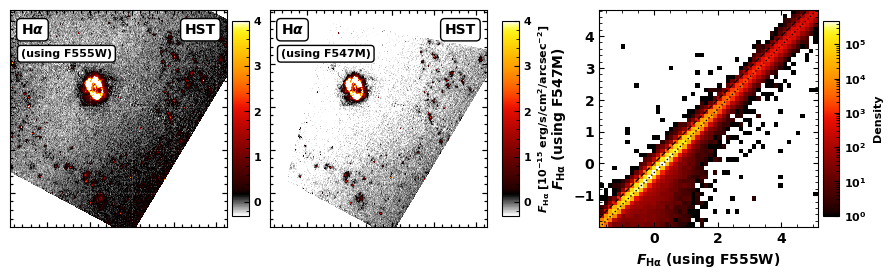

In [18]:
## Plot Maps... 
fig = plt.figure(figsize=(10, 10))
fig.tight_layout(h_pad=0, w_pad=0)
fig.subplots_adjust(left=0.05, right=0.95, top=0.95, bottom=0.05, wspace=-0.25, hspace=0.05)

vmin, vmax = -0.3*1e5, 4*1e5

hdus = [hdu_ngc3351_w555, hdu_ngc3351_w547]
label = [r'HST H$\alpha$ (using F555W)', r'HST H$\alpha$ (using F547M)']

for i, hdu_ in enumerate(hdus):

    col = i % 3
    row = i // 3

    factor = 1e5
    hdu = hdu_.copy()
    hdu.data = hdu.data / factor

    ax = fig.add_subplot(4, 3, i+1, projection=wcs.WCS(hdu.header))

    im1 = ax.imshow(hdu.data, cmap=cmap_map, origin='lower', vmin=vmin/factor, vmax=vmax/factor)

    try:

        ra = ax.coords[0]
        dec = ax.coords[1]

        ra.display_minor_ticks(True)
        dec.display_minor_ticks(True)

        ax.tick_params(axis='x', which='both', bottom=True, top=True, left=True, right=True)
        ax.tick_params(axis='y', which='both', bottom=True, top=True, left=True, right=True)
        ax.tick_params(axis='x', labelbottom=False, labelleft=False, labelright=False, labeltop=False)
        ax.tick_params(axis='y', labelbottom=False, labelleft=False, labelright=False, labeltop=False)

    except:

        ax.set_xticklabels([])
        ax.set_yticklabels([])

    ax.text(0.05, 0.94, label[i].split(' ')[1], transform=ax.transAxes, color='black', bbox=dict(facecolor='white', boxstyle='round', alpha=1), size=10, ha='left', va='top')
    ax.text(0.05, 0.82, ' '.join(label[i].split(' ')[2:]), transform=ax.transAxes, color='black', bbox=dict(facecolor='white', boxstyle='round', alpha=1), size=8, ha='left', va='top')
    ax.text(0.95, 0.94, label[i].split(' ')[0], transform=ax.transAxes, color='black', bbox=dict(facecolor='white', boxstyle='round', alpha=1), size=10, ha='right', va='top')

    ax.grid(True, alpha=0.3, ls=':', color='white')

    pos = ax.get_position()
    cax = fig.add_axes([pos.x1+pos.width*0.025, pos.y0+pos.height*0.05, pos.width*0.075, pos.height-pos.height*0.1])
    cbar = fig.colorbar(im1, cax=cax, orientation='vertical')
    cbar.ax.tick_params(axis='both', which='major', labelsize=8)

    if col == 1: 
        cbar.set_label(r'$F_\mathrm{H\alpha}$ [10$^{-15}$ erg/s/cm$^2$/arcsec$^{-2}$]', fontsize=8)

pos = ax.get_position()
new_pos = [pos.x0-0.01, pos.y0, pos.width, pos.height]
ax.set_position(new_pos)

## Plot Histograms...
data_x = hdus[0].data.flatten() / factor
data_y = hdus[1].data.flatten() / factor

mask_x = np.isfinite(data_x)
mask_y = np.isfinite(data_y)

mask = mask_x & mask_y

data_x = data_x[mask]
data_y = data_y[mask]

percentile_min = 0.5
percentile_max = 99.5

min_x, max_x = np.percentile(data_x, [percentile_min, percentile_max])
min_y, max_y = np.percentile(data_y, [percentile_min, percentile_max])

mask_x = (data_x >= min_x) & (data_x <= max_x)
mask_y = (data_y >= min_y) & (data_y <= max_y)

mask = mask_x & mask_y

data_x = data_x[mask]
data_y = data_y[mask]

ax = fig.add_subplot(4, 3, 3)
ax.set_aspect('equal')
ax.grid(True, alpha=0.3, ls=':', color='white')

counts, xedges, yedges, im2 = ax.hist2d(data_x, data_y, bins=50, cmap='cet_fire', norm=mpl.colors.LogNorm())
ax.plot([min_x, max_x], [min_x, max_x], 'k--', lw=1)
ax.plot([min_x, max_x], [min_x-0.3, max_x-0.3], 'k:', lw=1)

ax.set_xlabel(r'$F_\mathrm{H\alpha}$ (using F555W)', fontsize=10)
ax.set_ylabel(r'$F_\mathrm{H\alpha}$ (using F547M)', fontsize=10)

pos = ax.get_position()
new_pos = [pos.x0+0.05, pos.y0, pos.width, pos.height]
ax.set_position(new_pos)

pos = ax.get_position()
cax = fig.add_axes([pos.x1+pos.width*0.025, pos.y0+pos.height*0.05, pos.width*0.075, pos.height-pos.height*0.1])
cbar = fig.colorbar(im2, cax=cax, orientation='vertical')
cbar.ax.tick_params(axis='both', which='major', labelsize=8) 

cbar.set_label('Density', fontsize=8)

fig.savefig('./figs/ngc3351_contsub_comparison_f547m.pdf', bbox_inches='tight', dpi=300)  